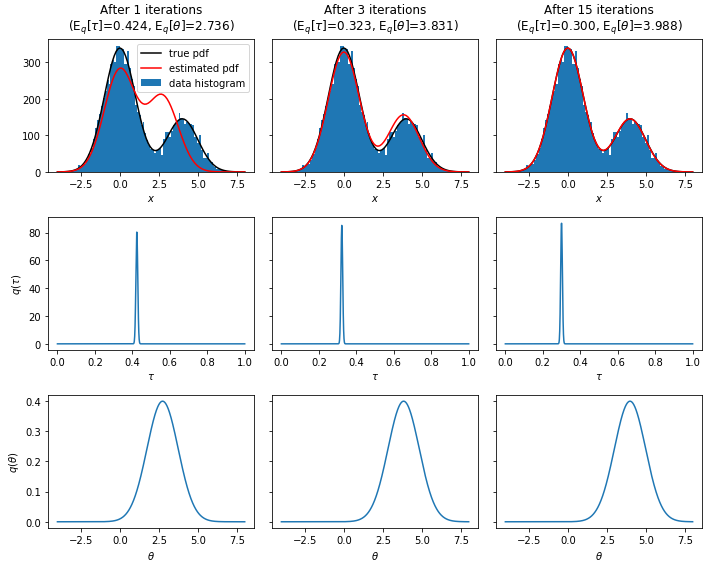

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, beta

np.random.seed(123123123)

# Simulate data
theta_true = 4
tau_true = 0.3
n_samples = 10000
z = (np.random.rand(n_samples) < tau_true)  # True with probability tau_true
x = np.random.randn(n_samples) + z * theta_true

# Parameters of the prior distributions.
alpha0 = 0.5
beta0 = 0.2

# The number of iterations
n_iter = 15

# Some initial value for the things that will be updated
E_log_tau = -0.7   # E(log(tau))
E_log_tau_c = -0.7  # E(log(1-tau))
E_log_var = 4 * np.ones(n_samples)  # E((x_n-theta)^2)
r2 = 0.5 * np.ones(n_samples)  # Responsibilities of the second cluster.

# init the plot
iters_to_plot = [0, 2, 14]
fig, ax = plt.subplots(3, len(iters_to_plot), figsize=(10, 8), sharex='row', sharey='row')
col = 0 # plot column

for i in range(n_iter):
    
    # Updated of responsibilites, factor q(z)
    log_rho1 = E_log_tau_c - 0.5 * np.log(2 * np.pi) - 0.5 * (x ** 2)
    log_rho2 = E_log_tau - 0.5 * np.log(2 * np.pi) - 0.5 * E_log_var
    max_log_rho = np.maximum(log_rho1, log_rho2)  # Normalize to avoid numerical problems when exponentiating.
    rho1 = np.exp(log_rho1 - max_log_rho)
    rho2 = np.exp(log_rho2 - max_log_rho)
    r2 = rho2 / (rho1 + rho2)
    r1 = 1 - r2
    
    N1 = np.sum(r1)
    N2 = np.sum(r2)
    
    # Update of factor q(tau)
    from scipy.special import psi # digamma function
    E_log_tau = psi(N2 + alpha0) - psi(N1 + N2 + 2*alpha0)# EXERCISE
    E_log_tau_c = psi(N1 + alpha0) - psi(N1 + N2 + 2*alpha0)# EXERCISE

    # Current estimate of tau
    tau_est = (N2 + alpha0) / (N1 + N2 + 2*alpha0)# EXERCISE: mean of q(tau)
     
    # Update of factor q(theta)
    beta2 = beta0 + N2 
    x2_ = 1 / N2 * np.sum(r2 @ x)
    m2 = 1/beta2 * N2 * x2_
    E_log_var = (x - m2)**2 + 1/beta2# EXERCISE
    
    # Current estimate theta
    theta_est = m2# EXERCISE: mean of q(theta)
    # plotting
    if i in iters_to_plot:
        # plot estimated data distribution
        xgrid = np.linspace(-4, 8, 100)
        ax[0,col].hist(x, xgrid, label="data histogram")
        pdf_true = (1-tau_true) * norm.pdf(xgrid, 0, 1) + tau_true * norm.pdf(xgrid, theta_true, 1)
        pdf_est = (1-tau_est) * norm.pdf(xgrid, 0, 1) + tau_est * norm.pdf(xgrid, theta_est, 1)
        ax[0,col].plot(xgrid, pdf_true * n_samples * (xgrid[1]-xgrid[0]), 'k', label="true pdf")
        ax[0,col].plot(xgrid, pdf_est * n_samples * (xgrid[1]-xgrid[0]), 'r', label="estimated pdf")
        if i == 0:
            ax[0,i].legend()
        ax[0,col].set_title(("After %d iterations\n" +
                            "($\\mathrm{E}_q[\\tau]$=%.3f, $\\mathrm{E}_q[\\theta]$=%.3f)") %
                            (i + 1, tau_est, theta_est))
        ax[0,col].set_xlabel("$x$")
        
        # plot marginal distribution of tau
        tau = np.linspace(0, 1.0, 1000)
        q_tau = beta.pdf(tau, N2 + alpha0, N1 + alpha0)
        ax[1,col].plot(tau, q_tau)
        ax[1,col].set_xlabel("$\\tau$")
        
        # plot marginal distribution of theta
        theta = np.linspace(-4.0, 8.0, 1000)
        q_theta = norm.pdf(theta, m2, 1.0)
        ax[2,col].plot(theta, q_theta)
        ax[2,col].set_xlabel("$\\theta$")
        col = col + 1

# finalize the plot
ax[1,0].set_ylabel("$q(\\tau)$")
ax[2,0].set_ylabel("$q(\\theta)$")
plt.tight_layout()
plt.show()


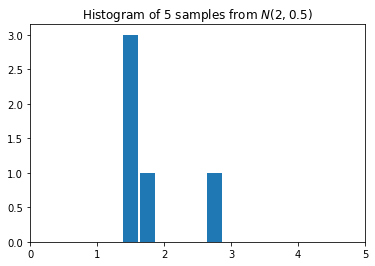

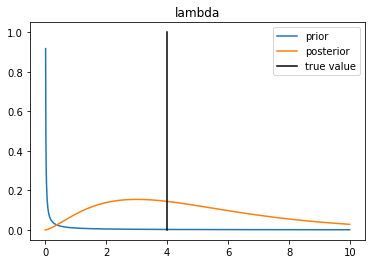

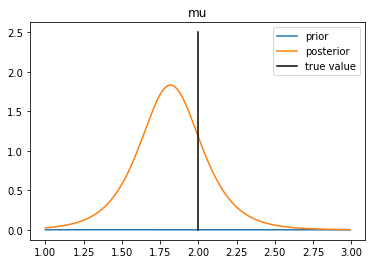

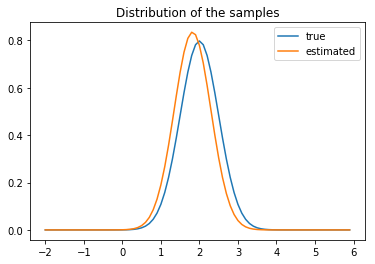

Samples of 5:
Use Sum:
KL_pq:  0.0720778066639
KL_qp:  0.065781800178
Use Numpy Integration Trapz:
KL_pq:  0.0720778066639
KL_qp:  0.065781800178


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# initialize the random number generator
np.random.seed(24)


# SIMULATE THE TRUE DATA SET
num_samples = 5   # Try e.g. values between 5 and 5000
mu_true = 2       # mean of the true distribution
lambda_true = 4   # precision of the true distribution
sigma_true = 1 / np.sqrt(lambda_true)    # standard deviation
data_set = np.random.normal(mu_true, sigma_true, num_samples)

# plot the data set as a histogram
plt.xlim([0, 5])
plt.hist(data_set, np.arange(0.125, 4, 0.25), rwidth=0.9)
plt.title("Histogram of $%i$ samples from $N(%s, %s)$" % (num_samples, mu_true, sigma_true))
plt.show()



# SPECIFY PRIORS

# lambda is the precision parameter of the unknown Gaussian
# and it is given a prior distribution Gamma(a0,b0),
# (a0 is the 'shape' and b0 the 'rate')
a0 = 0.01
b0 = 0.01   # These correspond to a noninformative prior

# mu is the mean parameter of the unknown Gaussian
# and it is given a prior distribution that depends on
# lambda: N(mu0, (beta0*lambda)^-1)
mu0 = 0
beta0 = 0.001   # Low precision corresponds to high variance

# (This is the so-called Normal-Gamma(mu0, beta0, a0, b0) prior distribution for mu and lambda)


# LEARN THE POSTERIOR DISTRIBUTION

# Due to conjugacy, the posterior distribution is also Normal-Gamma(mu_n, beta_n, a_n, b_n)

sample_mean = np.mean(data_set)
sample_var = np.var(data_set)

mu_n = (mu0 * beta0 + num_samples * sample_mean) / (beta0 + num_samples)

beta_n = beta0 + num_samples

a_n = a0 + num_samples / 2

b_n = b0 + (num_samples * sample_var + (beta0 * num_samples * (sample_mean - mu0) ** 2)
           / (beta0 + num_samples)) / 2



# PLOT THE PRIOR AND THE POSTERIOR DISTRIBUTIONS

# Plot distribution of lambda, the precision
lambda_range = np.arange(0, 10, 0.01)
prior_lambda_pdf = gamma.pdf(lambda_range, a0, scale=1/b0)
posterior_lambda_pdf = gamma.pdf(lambda_range, a_n, scale=1/b_n)

plt.plot(lambda_range, prior_lambda_pdf, label="prior")
plt.plot(lambda_range, posterior_lambda_pdf, label="posterior")
plt.plot([lambda_true,lambda_true], [0,1], "k-", label="true value")
plt.title('lambda')
plt.legend()
plt.show()

# Plot distribution of mu, the mean
mu_range = np.arange(1, 3, 0.01)

# Because mu depends on lambda, we need to integrate over lambda.
# We do this by Monte Carlo integration (i.e. average over multiple simulated lambdas)
def mu_pdf_monte_carlo(a, b, mu, beta):
	gamma_samples = np.random.gamma(a, 1/b, 100)
	sum_mu_pdf = np.zeros(len(mu_range))
	for gamma_sample in gamma_samples:
		mu_pdf = norm.pdf(mu_range, mu, 1 / np.sqrt((beta * gamma_sample)))
		sum_mu_pdf += mu_pdf
	mu_pdf = sum_mu_pdf / len(gamma_samples)
	return mu_pdf

prior_mu_pdf     = mu_pdf_monte_carlo(a0,  b0,  mu0,  beta0)
posterior_mu_pdf = mu_pdf_monte_carlo(a_n, b_n, mu_n, beta_n)

plt.plot(mu_range, prior_mu_pdf, label="prior")
plt.plot(mu_range, posterior_mu_pdf, label="posterior")
plt.plot([mu_true,mu_true],[0,2.5], "k-", label="true value")
plt.title('mu')
plt.legend()
plt.show()


# PLOT THE TRUE AND ESTIMATED DISTRIBUTIONS OF THE SAMPLES

# We estimate the parameters with the mean of the posterior distribution
mu_hat = np.sum(posterior_mu_pdf * mu_range) / np.sum(posterior_mu_pdf)
lambda_hat = np.sum(posterior_lambda_pdf * lambda_range) / np.sum(posterior_lambda_pdf)

full_dist_range = np.arange(-2, 6, 0.1)
true_pdf = norm.pdf(full_dist_range, mu_true, sigma_true)
estimated_pdf = norm.pdf(full_dist_range, mu_hat, 1 / np.sqrt(lambda_hat))

plt.plot(full_dist_range, true_pdf, label="true")
plt.plot(full_dist_range, estimated_pdf, label="estimated")
plt.title('Distribution of the samples')
plt.legend()
plt.show()


# COMPUTE K-L DIVERGENCE BETWEEN TRUE AND ESTIMATED SAMPLE DISTRIBUTIONS

# Hints for the exercise:
# For computing the KL-divergence, use numerical integration over a grid of
# values. "full_dist_range" specifies a suitable grid along the x-axis.

# Values of the true PDF estimated at the grid points are given in 
# "true_pdf" and values of the estimated PDF at the grid points are given
# in "estimated_pdf". 

# For computing the integral, you can use any numerical
# integration available in Numpy, e.g., the "trapz" function.

print('Samples of 5:')
print('Use Sum:')
KL_pq = np.sum(true_pdf * np.log(true_pdf/estimated_pdf)) /np.sum(true_pdf)
KL_qp = np.sum(estimated_pdf * np.log(estimated_pdf/true_pdf))/np.sum(estimated_pdf)

print('KL_pq: ',KL_pq)
print('KL_qp: ',KL_qp)

print('Use Numpy Integration Trapz:')
KL_pq2 = np.trapz( y= (true_pdf * np.log(true_pdf/estimated_pdf)), x = full_dist_range)
KL_qp2 = np.trapz( y= (estimated_pdf * np.log(estimated_pdf/true_pdf)), x = full_dist_range)

print('KL_pq: ',KL_pq2)
print('KL_qp: ',KL_qp2)



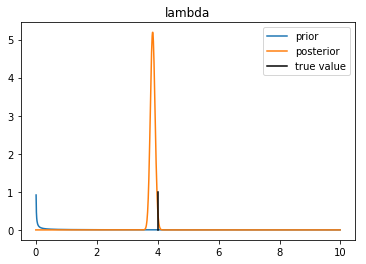

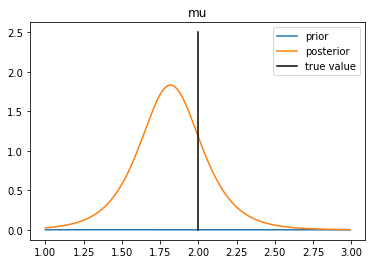

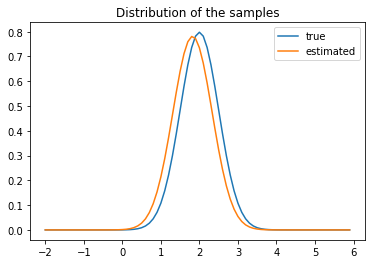

Samples of 5:
Use Sum:
KL_pq:  0.0615466323942
KL_qp:  0.0641509202025
Use Numpy Integration Trapz:
KL_pq:  0.0615466323942
KL_qp:  0.0641509202024

Range from 5 to 5000:


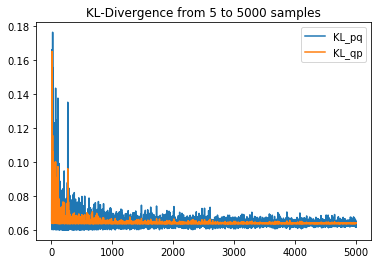

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Initialize the random number generator
np.random.seed(24)

# SIMULATE THE TRUE DATA SET
num_samples = 5
mu_true = 2       # mean of the true distribution
lambda_true = 4   # precision of the true distribution
sigma_true = 1 / np.sqrt(lambda_true)    # standard deviation
lambda_range = np.arange(0, 10, 0.01)
full_dist_range = np.arange(-2, 6, 0.1)
a0 = 0.01
b0 = 0.01  
mu0 = 0
beta0 = 0.001 
data_set = np.random.normal(mu_true, sigma_true, num_samples)
sample_mean = np.mean(data_set)
sample_var = np.var(data_set)
# PLOT THE PRIOR AND THE POSTERIOR DISTRIBUTIONS

# Plot distribution of lambda, the precision
lambda_range = np.arange(0, 10, 0.01)
prior_lambda_pdf = gamma.pdf(lambda_range, a0, scale=1/b0)
posterior_lambda_pdf = gamma.pdf(lambda_range, a_n, scale=1/b_n)

plt.plot(lambda_range, prior_lambda_pdf, label="prior")
plt.plot(lambda_range, posterior_lambda_pdf, label="posterior")
plt.plot([lambda_true,lambda_true], [0,1], "k-", label="true value")
plt.title('lambda')
plt.legend()
plt.show()

plt.plot(mu_range, prior_mu_pdf, label="prior")
plt.plot(mu_range, posterior_mu_pdf, label="posterior")
plt.plot([mu_true,mu_true],[0,2.5], "k-", label="true value")
plt.title('mu')
plt.legend()
plt.show()


# PLOT THE TRUE AND ESTIMATED DISTRIBUTIONS OF THE SAMPLES

# We estimate the parameters with the mean of the posterior distribution
mu_hat = np.sum(posterior_mu_pdf * mu_range) / np.sum(posterior_mu_pdf)
lambda_hat = np.sum(posterior_lambda_pdf * lambda_range) / np.sum(posterior_lambda_pdf)

full_dist_range = np.arange(-2, 6, 0.1)
true_pdf = norm.pdf(full_dist_range, mu_true, sigma_true)
estimated_pdf = norm.pdf(full_dist_range, mu_hat, 1 / np.sqrt(lambda_hat))

plt.plot(full_dist_range, true_pdf, label="true")
plt.plot(full_dist_range, estimated_pdf, label="estimated")
plt.title('Distribution of the samples')
plt.legend()
plt.show()

print('Samples of 5:')
print('Use Sum:')
KL_pq = np.sum(true_pdf * np.log(true_pdf/estimated_pdf)) /np.sum(true_pdf)
KL_qp = np.sum(estimated_pdf * np.log(estimated_pdf/true_pdf))/np.sum(estimated_pdf)

print('KL_pq: ',KL_pq)
print('KL_qp: ',KL_qp)

print('Use Numpy Integration Trapz:')
KL_pq2 = np.trapz( y= (true_pdf * np.log(true_pdf/estimated_pdf)), x = full_dist_range)
KL_qp2 = np.trapz( y= (estimated_pdf * np.log(estimated_pdf/true_pdf)), x = full_dist_range)

print('KL_pq: ',KL_pq2)
print('KL_qp: ',KL_qp2)

##################################################################

print('\nRange from 5 to 5000:')
KL_pq_list = []
KL_qp_list = []
for i in range(5,5000,1):
    num_samples = i
    data_set = np.random.normal(mu_true, sigma_true, num_samples)
    
    sample_mean = np.mean(data_set)
    sample_var = np.var(data_set)

    mu_n = (mu0 * beta0 + num_samples * sample_mean) / (beta0 + num_samples)
    beta_n = beta0 + num_samples
    a_n = a0 + num_samples / 2
    b_n = b0 + (num_samples * sample_var + (beta0 * num_samples * (sample_mean - mu0) ** 2)
           / (beta0 + num_samples)) / 2
    
    # Plot distribution of lambda, the precision
    prior_lambda_pdf = gamma.pdf(lambda_range, a0, scale=1/b0)
    posterior_lambda_pdf = gamma.pdf(lambda_range, a_n, scale=1/b_n)
    mu_hat = np.sum(posterior_mu_pdf * mu_range) / np.sum(posterior_mu_pdf)
    lambda_hat = np.sum(posterior_lambda_pdf * lambda_range) / np.sum(posterior_lambda_pdf)

    true_pdf = norm.pdf(full_dist_range, mu_true, sigma_true)
    estimated_pdf = norm.pdf(full_dist_range, mu_hat, 1 / np.sqrt(lambda_hat))
    
    KL_pq = np.sum(true_pdf * np.log(true_pdf/estimated_pdf)) /np.sum(true_pdf)
    KL_pq_list.append(KL_pq)
    
    KL_qp = np.sum(estimated_pdf * np.log(estimated_pdf/true_pdf))/np.sum(estimated_pdf)
    KL_qp_list.append(KL_qp)
    

plt.title("KL-Divergence from 5 to 5000 samples")
plt.plot(range(5,5000,1),KL_pq_list, label="KL_pq")
plt.plot(range(5,5000,1),KL_qp_list, label="KL_qp")
plt.legend()
plt.show()